### Coconut Disease Identification using transfer learning

<br>

**Problem**: classify and predict coconut disease
<br>
**Solution:**
* model used: EfficientNet_B4
* pretrained on: ImageNet (ILSVRC-2012-CLS)
* new classes: 3




In [ ]:
# standard libraries
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import requests

# tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [3]:
# path variables
train_path = '/content/gdrive/MyDrive/Colab Notebooks/drone/'

# define some variables
batch_size = 32
img_height = 300  # reduced from 600 to mitigate the memory issue
img_width = 300   # reduced from 600 to mitigate the memory issue
seed_train_validation = 1
shuffle_value = True
validation_split = 0.4


# load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=validation_split,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed = seed_train_validation,
  shuffle = shuffle_value )

# load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed = seed_train_validation,
    shuffle = shuffle_value )
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

Found 2172 files belonging to 3 classes.
Using 1304 files for training.
Found 2172 files belonging to 3 classes.
Using 868 files for validation.


In [4]:
# target class names
class_names = train_ds.class_names
print(class_names)
# cleaning the class names
class_names = [x.split('_')[1] for x in class_names]

# view class names
print("the target classes are: ",*class_names, sep =" ,")

the target classes are:  ,DryingofLeaflets ,Yellowing ,Healthy


In [ ]:
# rescaling the images for the model
'''TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range'''

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.


'''finish the input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# get the headless model
'''TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.'''

# feature vector model
efficientnet_b4_fv = 'https://kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b4-feature-vector/versions/1'
feature_extractor_model = efficientnet_b4_fv

# feature extraction layer
'''Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer'''
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)

# add a classification layer
num_classes = len(class_names)

model2 = tf.keras.Sequential([
  feature_extractor_layer,
   tf.keras.layers.Dropout(0.95),
  tf.keras.layers.Dense(num_classes)
])

# model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2560)              64097680  
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 2)                 5122      
                                                                 
Total params: 64102802 (244.53 MB)
Trainable params: 5122 (20.01 KB)
Non-trainable params: 64097680 (244.51 MB)
_________________________________________________________________


In [ ]:
# compile the model
model2.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Define Epochs
NUM_EPOCHS2 = 50

In [2]:
# train the model
history2 = model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS2,
                    callbacks=[TqdmCallback(verbose=1)],verbose=1)

# view model accuracy
model_acc2 = '{:.2%}'.format(history2.history['acc'][-1])
print(f"\n Model Accuracy Reached: {model_acc2}")


Epoch 1/50
41/41 [==============================] - 43s 1s/step - loss: 0.1977 - acc: 0.9233 - val_loss: 0.0847 - val_acc: 0.9643
Epoch 2/50
41/41 [==============================] - 47s 1s/step - loss: 0.2104 - acc: 0.9202 - val_loss: 0.0850 - val_acc: 0.9654
Epoch 3/50
41/41 [==============================] - 43s 1s/step - loss: 0.2085 - acc: 0.9156 - val_loss: 0.0839 - val_acc: 0.9689
Epoch 4/50
41/41 [==============================] - 47s 1s/step - loss: 0.2146 - acc: 0.9110 - val_loss: 0.0815 - val_acc: 0.9677
Epoch 5/50
41/41 [==============================] - 43s 1s/step - loss: 0.2144 - acc: 0.9164 - val_loss: 0.0862 - val_acc: 0.9700
Epoch 6/50
41/41 [==============================] - 43s 1s/step - loss: 0.2021 - acc: 0.9241 - val_loss: 0.0808 - val_acc: 0.9643
Epoch 7/50
41/41 [==============================] - 43s 1s/step - loss: 0.1938 - acc: 0.9248 - val_loss: 0.0814 - val_acc: 0.9643
Epoch 8/50
41/41 [==============================] - 43s 1s/step - loss: 0.1842 - acc: 0.9

In [ ]:
# Save the model
model_save_path = '/content/gdrive/MyDrive/Colab Notebooks/drone/model2.h5'
model2.save(model_save_path)
print(f"Model saved at: {model_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/gdrive/MyDrive/Colab Notebooks/drone/model2.h5


In [ ]:
# Assuming model.predict returns probabilities
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Assuming a classification problem with one-hot encoded labels

# Assuming val_labels is the true labels for your validation set
y_true = val_labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Precision
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print(f"Precision: {precision}")

# Calculate Recall
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print(f"Recall: {recall}")

28/28 [==============================] - 24s 624ms/step
Confusion Matrix:
[[ 259 16   23]
 [ 16 259   23]
 [  16  23   259]]
Precision: 0.9466442953020134
Recall: 0.9244859813084113


### Well it looks like our model is accurately predicting the class for an unseen random image from the internet.

1/1 [==============================] - 0s 57ms/step
[array([[ 3.7618985, -3.8433197]], dtype=float32), array([[ 0.624087 , -0.7392947]], dtype=float32), array([[-0.57657456,  0.40136394]], dtype=float32), array([[ 1.6579887, -1.6068472]], dtype=float32), array([[ 3.982912 , -4.5226855]], dtype=float32), array([[ 1.7915049, -1.870442 ]], dtype=float32), array([[ 3.764717, -3.736105]], dtype=float32), array([[ 3.7932959, -3.6152284]], dtype=float32), array([[ 1.4144208, -1.2096016]], dtype=float32), array([[ 3.2594829, -3.5084777]], dtype=float32), array([[ 1.3187882, -1.7635316]], dtype=float32), array([[ 0.52152383, -0.6885812 ]], dtype=float32), array([[ 1.0281757, -1.264092 ]], dtype=float32), array([[ 0.45248076, -0.6002034 ]], dtype=float32), array([[ 0.3655605, -0.8999399]], dtype=float32), array([[ 2.5600863, -2.7722573]], dtype=float32), array([[ 0.00083403, -0.4828581 ]], dtype=float32), array([[-1.0507905,  0.8905424]], dtype=float32), array([[ 3.6916342, -4.0730767]], dtype=f

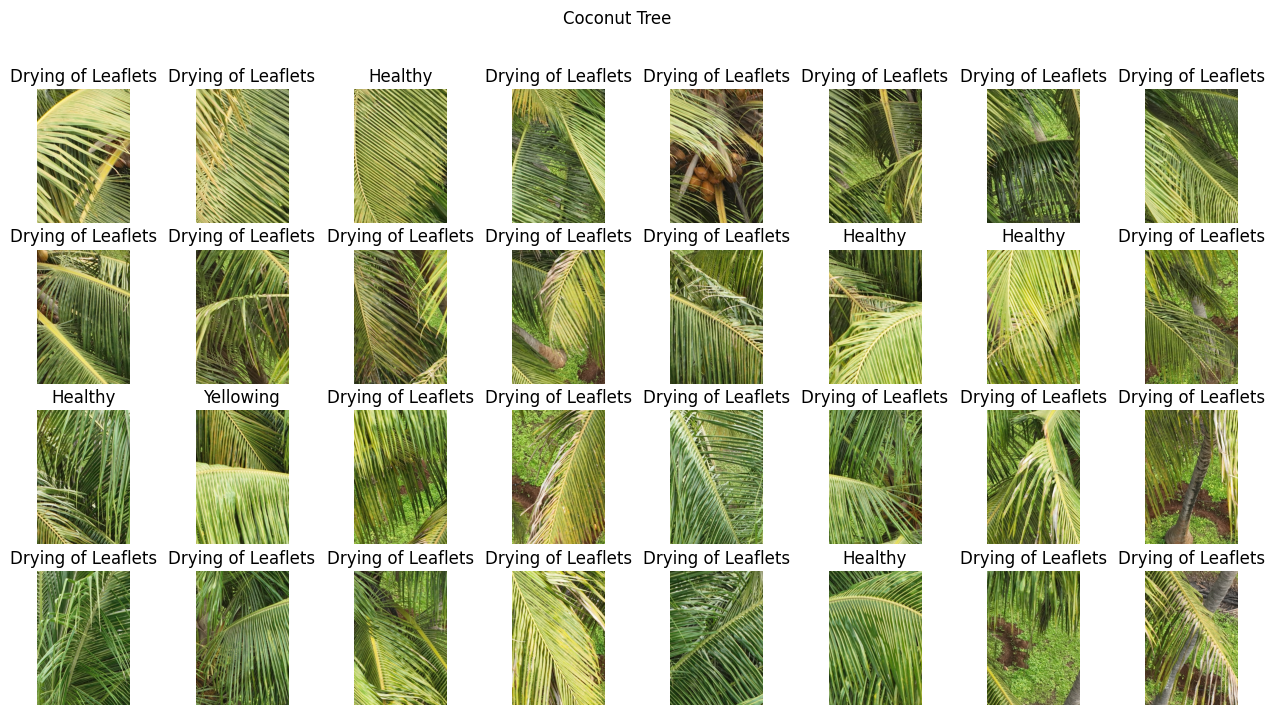

In [ ]:
from PIL import Image
import numpy as np
import os

def split_image(image_path, output_dir, num_splits=32):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Determine the size of each smaller image
    split_width = img_width // 8
    split_height = img_height // 4

    # Initialize an array to store the smaller images
    image_array = []

    # Split the image into smaller parts
    for i in range(8):
        for j in range(4):
            left = i * split_width
            top = j * split_height
            right = (i + 1) * split_width
            bottom = (j + 1) * split_height
            cropped_image = image.crop((left, top, right, bottom))

            # Save the smaller image
            cropped_image_path = os.path.join(output_dir, f'img_{i}_{j}.png')
            cropped_image.save(cropped_image_path)

            # Append the smaller image to the array
            image_array.append(np.array(cropped_image))

    return image_array

# Example usage
image_path = '/content/gdrive/MyDrive/Colab Notebooks/drone/test.JPG'  # Replace with your image path
output_dir = '/content/gdrive/MyDrive/Colab Notebooks/drone/splitted'
image_array = split_image(image_path, output_dir)

# The image_array now contains the 32 smaller images ready for prediction
# Preprocess images and make predictions
predictions = []
for img in image_array:
    img = img.astype('float32') / 255.0  # Normalize the image if required
    img = np.expand_dims(img, axis=0)    # Expand dimensions to match model input shape
    prediction = model2.predict(img)
    predictions.append(prediction)
print(predictions)

num_columns = 8
num_rows = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*2, num_rows*2))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
for i in range(num_columns * num_rows):
    if i < len(image_array):
        axes[i].imshow(image_array[i])
        axes[i].set_title(f"{predictions[i]}")
        axes[i].axis('off')
    else:
        axes[i].axis('off')  # Hide any unused axes
plt.suptitle("Coconut Tree")
plt.show()